In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import scikitplot as skplt

from IPython.display import Image
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
from scipy import interp
from scipy.stats import randint as sp_randint
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, classification_report, make_scorer, \
                            roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with labels given by the clustering)

## Decision tree

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)
customer_clustering = pd.read_csv('datasets/clustering_labels.csv', index_col=0)
customer_clustering = customer_profile[['CustomerID', 'Delta','Median', 'RFrequency']].merge(customer_clustering[['CustomerID', 'Label']], on='CustomerID')
del customer_profile
customer_clustering

,CustomerID,Delta,Median,RFrequency,Label
0,12347,366,584.910,0.019126,High
1,12348,283,298.500,0.014134,Medium
2,12350,1,294.400,1.000000,Low
3,12352,261,226.250,0.026820,Medium
4,12353,1,89.000,1.000000,Low
...,...,...,...,...,...
3855,18280,1,180.600,1.000000,Low
3856,18281,1,80.820,1.000000,Low
3857,18282,119,89.025,0.016807,Medium
3858,18283,334,113.500,0.047904,Medium


In [3]:
df_majority = customer_clustering[customer_clustering.Label == 'Medium']
df_minority = customer_clustering[customer_clustering.Label == 'High']
df_middle   = customer_clustering[customer_clustering.Label == 'Low']

customer_clustering.Label.value_counts()

Medium    1698
Low       1250
High       912
Name: Label, dtype: int64

In [4]:
# Oversample minority classes.

df_minority_oversampled = resample(df_minority,
                                   replace=True,  # Sample with replacement.
                                   n_samples=len(df_majority))

df_middle_oversampled = resample(df_middle,
                                 replace=True,
                                 n_samples=len(df_majority))

# Combine majority class with oversampled minority classes.
df_oversampled = pd.concat([df_majority, df_minority_oversampled, df_middle_oversampled])
 
# Display new class counts.
customer_labeled = df_oversampled
df_oversampled.Label.value_counts()

Low       1698
Medium    1698
High      1698
Name: Label, dtype: int64

In [5]:
'''
# Undersampling.

df_majority_undersampled = resample(df_majority, 
                                    replace=False,  # Sample without replacement.
                                    n_samples=len(df_minority))

df_middle_undersampled = resample(df_middle, 
                                  replace=False,
                                  n_samples=len(df_minority))

df_undersampled = pd.concat([df_minority, df_majority_undersampled, df_middle_undersampled])

customer_clustering = df_undersampled
df_undersampled.Label.value_counts()
'''

'\n# Undersampling.\n\ndf_majority_undersampled = resample(df_majority, \n                                    replace=False,  # Sample without replacement.\n                                    n_samples=len(df_minority))\n\ndf_middle_undersampled = resample(df_middle, \n                                  replace=False,\n                                  n_samples=len(df_minority))\n\ndf_undersampled = pd.concat([df_minority, df_majority_undersampled, df_middle_undersampled])\n\ncustomer_clustering = df_undersampled\ndf_undersampled.Label.value_counts()\n'

In [6]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [7]:
variables = ['Label']

# Discretize data, in this case only Label
customer_clustering = discretize_data(customer_clustering, variables)

# Drop the categorical variables since we don't need them anymore 
customer_clustering = customer_clustering[['Delta', 'Median', 'Label_num']]

label = customer_clustering.pop('Label_num')

scaler = StandardScaler()
customer_clustering = scaler.fit_transform(customer_clustering.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_clustering, label, stratify=label, test_size=0.3)

## Expected prediction

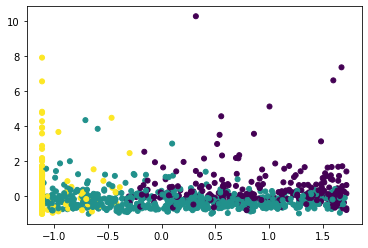

In [8]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_label.values, s=25)
plt.show()

## Decision Tree

In [9]:
# Decision tree

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12],
              "min_samples_split": sp_randint(20, 30),
              "min_samples_leaf": sp_randint(5, 30),
              "criterion": ["entropy", "gini"],
              "splitter": ["best"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()

grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist, 
                                 n_iter=n_iter_search, 
                                 n_jobs=10, 
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [10]:
print('Best setting parameters ', grid_search.best_params_)

Best setting parameters  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 28, 'min_samples_split': 26, 'splitter': 'best'}


In [11]:
# Decision tree best setting parameters

dec_t = tree.DecisionTreeClassifier(**grid_search.best_params_).fit(train_set, train_label)

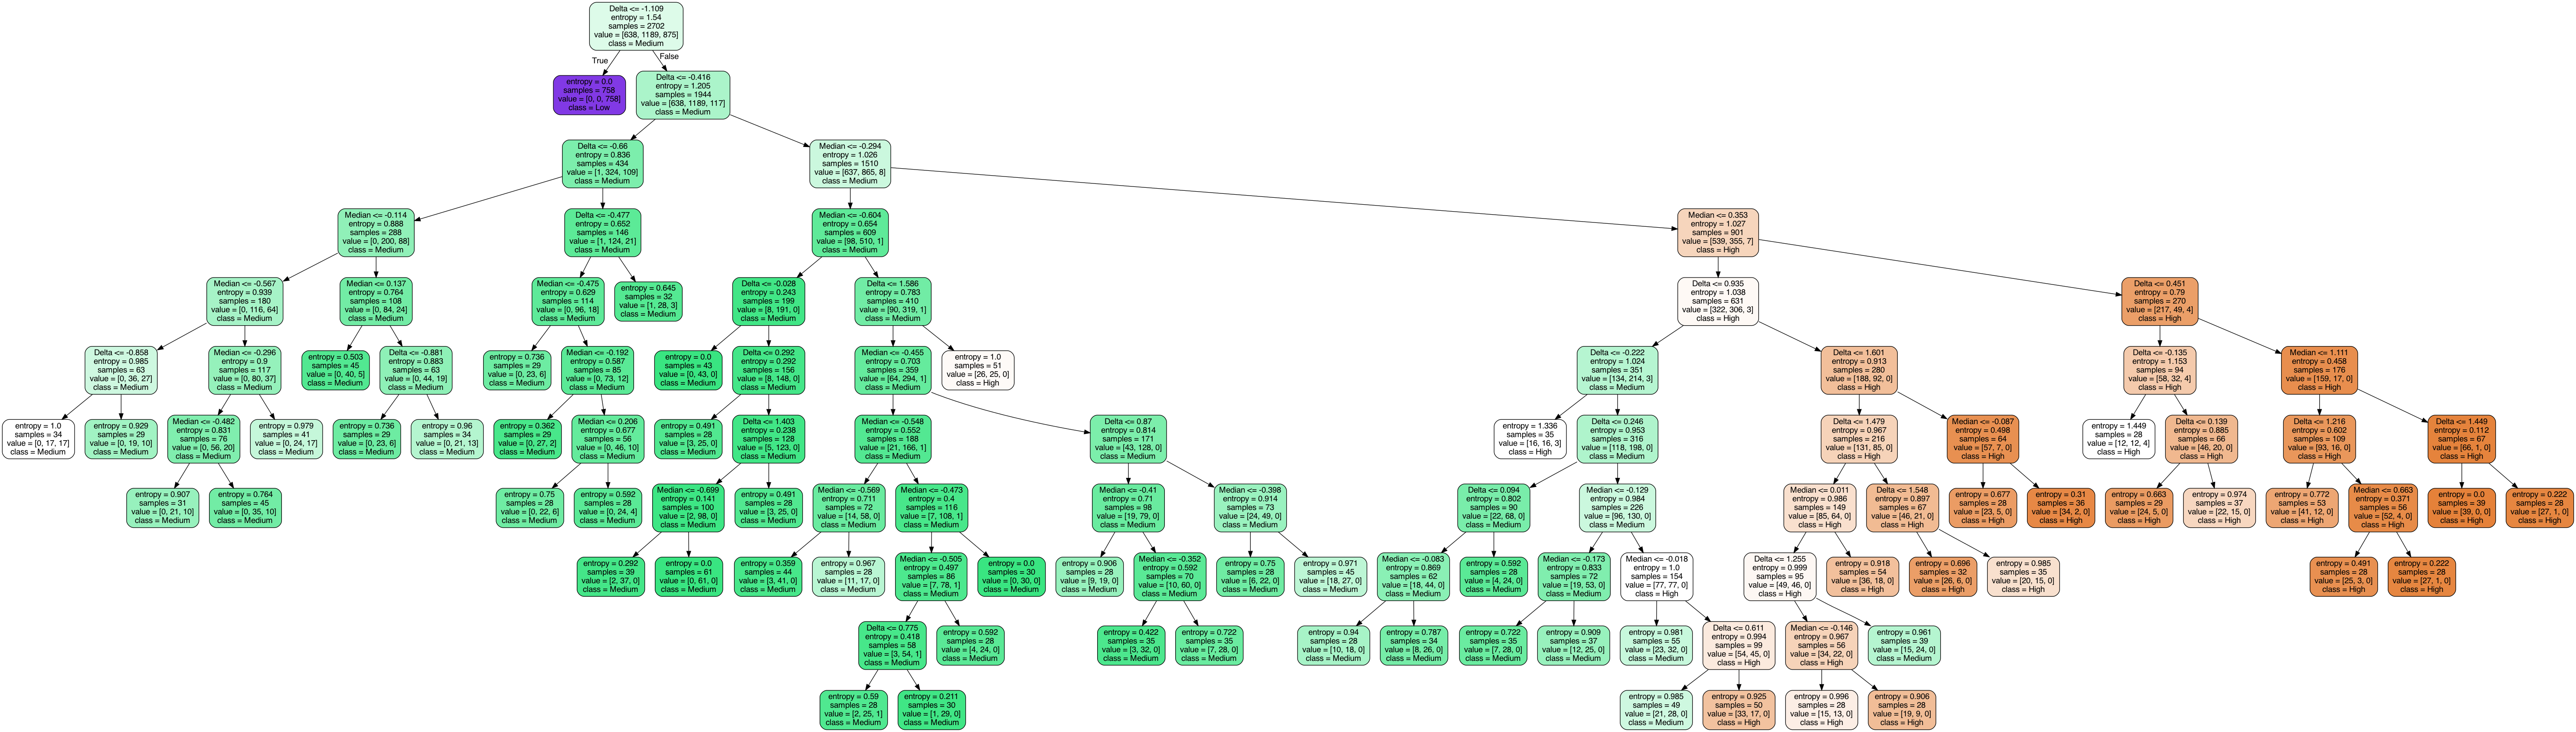

In [12]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Delta', 'Median'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [13]:
def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

In [14]:
# Predict phase

train_pred_dt, test_pred_dt = predict(dec_t, train_set, test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [15]:
def print_scores(train_label, train_pred, test_label, test_pred, target_names_):
    print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred))
    print()
    print('F1 score train set:', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set: ', metrics.f1_score(test_label, test_pred, average='weighted'))
    print('Train:')
    print(classification_report(train_label, train_pred, target_names=target_names_))
    print('-' * 53)
    print('Test:')
    print(classification_report(test_label, test_pred, target_names=target_names_))

In [16]:
print_scores(train_label, train_pred_dt, test_label, test_pred_dt, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8279052553663953
Accuracy test set:  0.8169257340241797

F1 score train set: 0.8304960535684646
F1 score test set:  0.8195941381521065
Train:
              precision    recall  f1-score   support

        High       0.72      0.73      0.72       638
      Medium       0.78      0.85      0.82      1189
         Low       1.00      0.87      0.93       875

    accuracy                           0.83      2702
   macro avg       0.83      0.82      0.82      2702
weighted avg       0.84      0.83      0.83      2702

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.68      0.69      0.68       274
      Medium       0.77      0.83      0.80       509
         Low       1.00      0.89      0.94       375

    accuracy                           0.82      1158
   macro avg       0.82      0.80      0.81      1158
weighted avg       0.83      0.82      0.82      1158



In [17]:
# Compute confusion matrix.

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[ 465  173    0]
 [ 175 1014    0]
 [   7  110  758]]
------------------
Test:
[[189  85   0]
 [ 87 422   0]
 [  2  38 335]]


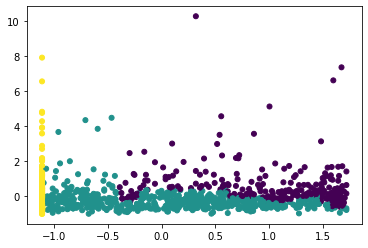

In [18]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_dt, s=25)
plt.show()

## SVM

In [19]:
# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm = SVC(kernel='rbf', C=0.75).fit(train_set, train_label)
svm_binarize = OneVsRestClassifier(svm).fit(train_set, train_label_binarized)

In [20]:
# Predictions

train_pred_svm_binarized, test_pred_svm_binarized = predict(svm_binarize, train_set, test_set)
train_pred_svm, test_pred_svm = predict(svm, train_set, test_set)

In [21]:
# Compute the performance of the model

print_scores(train_label, train_pred_svm, test_label, test_pred_svm, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8008882309400445
Accuracy test set:  0.803972366148532

F1 score train set: 0.7979772426213146
F1 score test set:  0.8006387224809501
Train:
              precision    recall  f1-score   support

        High       0.77      0.60      0.67       638
      Medium       0.75      0.83      0.79      1189
         Low       0.90      0.91      0.90       875

    accuracy                           0.80      2702
   macro avg       0.81      0.78      0.79      2702
weighted avg       0.80      0.80      0.80      2702

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.75      0.60      0.66       274
      Medium       0.75      0.82      0.79       509
         Low       0.91      0.93      0.92       375

    accuracy                           0.80      1158
   macro avg       0.80      0.78      0.79      1158
weighted avg       0.80      0.80      0.80      1158



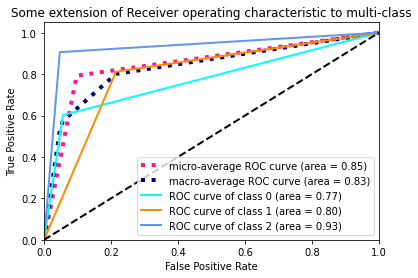

In [22]:
n_classes = 3
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

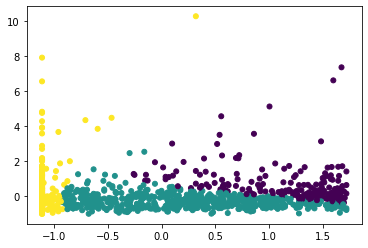

In [23]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_svm, s=25)
plt.show()

## KNN

In [24]:
knn = KNeighborsClassifier(n_neighbors=8, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [25]:
train_pred_knn, test_pred_knn = predict(knn, train_set, test_set)

In [26]:
print_scores(train_label, train_pred_knn, test_label, test_pred_knn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8275351591413768
Accuracy test set:  0.8082901554404145

F1 score train set: 0.8297391090626438
F1 score test set:  0.8104826282985671
Train:
              precision    recall  f1-score   support

        High       0.72      0.77      0.74       638
      Medium       0.80      0.82      0.81      1189
         Low       0.97      0.88      0.92       875

    accuracy                           0.83      2702
   macro avg       0.83      0.82      0.82      2702
weighted avg       0.83      0.83      0.83      2702

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.67      0.73      0.70       274
      Medium       0.79      0.78      0.78       509
         Low       0.96      0.91      0.93       375

    accuracy                           0.81      1158
   macro avg       0.80      0.81      0.80      1158
weighted avg       0.81      0.81      0.81      1158



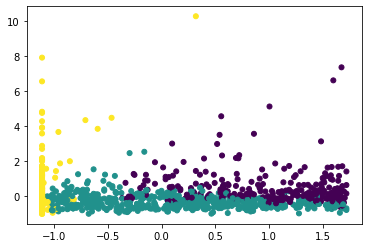

In [27]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_knn, s=25)
plt.show()

## Classification with Random Forest

In [28]:
# Define and fit a random forest.

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": sp_randint(1, len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight": ['balanced', None, {0: 0.25, 1: 0.50, 2: 0.25}]}

n_iter_search = 50

rf = RandomForestClassifier(n_estimators=30)
grid_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                 n_iter=n_iter_search, 
                                 n_jobs=10, 
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [29]:
print('Best setting parameters ', grid_search.best_params_)

Best setting parameters  {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 2, 'min_samples_leaf': 33, 'min_samples_split': 45}


In [30]:
rf = RandomForestClassifier(**grid_search.best_params_).fit(train_set, train_label)

In [31]:
train_pred_rf, test_pred_rf = predict(rf, train_set, test_set)

In [32]:
print_scores(train_label, train_pred_rf, test_label, test_pred_rf, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8286454478164322
Accuracy test set:  0.8281519861830743

F1 score train set: 0.8300360209175305
F1 score test set:  0.8296991201239244
Train:
              precision    recall  f1-score   support

        High       0.75      0.69      0.72       638
      Medium       0.77      0.87      0.82      1189
         Low       1.00      0.87      0.93       875

    accuracy                           0.83      2702
   macro avg       0.84      0.81      0.82      2702
weighted avg       0.84      0.83      0.83      2702

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.72      0.68      0.70       274
      Medium       0.78      0.86      0.82       509
         Low       1.00      0.89      0.94       375

    accuracy                           0.83      1158
   macro avg       0.83      0.81      0.82      1158
weighted avg       0.84      0.83      0.83      1158



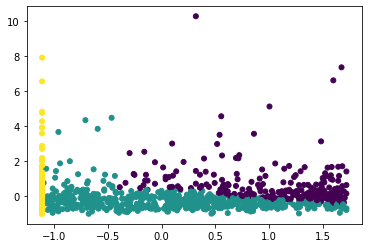

In [33]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_rf, s=25)
plt.show()

## Neural networks

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [36]:
history = model.fit(train_set, train_label_nn,
                    epochs=100,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/100
8/8 [==============================] - 0s 24ms/step - loss: 1.0697 - accuracy: 0.4294 - val_loss: 1.0291 - val_accuracy: 0.5623
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0397 - accuracy: 0.4818 - val_loss: 1.0082 - val_accuracy: 0.5919
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0090 - accuracy: 0.5574 - val_loss: 0.9871 - val_accuracy: 0.6153
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.9886 - accuracy: 0.5918 - val_loss: 0.9648 - val_accuracy: 0.6215
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.9665 - accuracy: 0.6161 - val_loss: 0.9411 - val_accuracy: 0.6326
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9405 - accuracy: 0.6214 - val_loss: 0.9166 - val_accuracy: 0.6387
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9150 - accuracy: 0.6319 - val_loss: 0.8908 - val_accuracy: 0.6498
Epoch 8/100
8/8 [=========

8/8 [==============================] - 0s 5ms/step - loss: 0.5247 - accuracy: 0.7626 - val_loss: 0.4944 - val_accuracy: 0.7596
Epoch 60/100
8/8 [==============================] - 0s 5ms/step - loss: 0.5160 - accuracy: 0.7657 - val_loss: 0.4933 - val_accuracy: 0.7596
Epoch 61/100
8/8 [==============================] - 0s 5ms/step - loss: 0.5143 - accuracy: 0.7668 - val_loss: 0.4924 - val_accuracy: 0.7596
Epoch 62/100
8/8 [==============================] - 0s 5ms/step - loss: 0.5195 - accuracy: 0.7610 - val_loss: 0.4913 - val_accuracy: 0.7608
Epoch 63/100
8/8 [==============================] - 0s 4ms/step - loss: 0.5212 - accuracy: 0.7678 - val_loss: 0.4909 - val_accuracy: 0.7620
Epoch 64/100
8/8 [==============================] - 0s 5ms/step - loss: 0.5136 - accuracy: 0.7684 - val_loss: 0.4904 - val_accuracy: 0.7645
Epoch 65/100
8/8 [==============================] - 0s 4ms/step - loss: 0.5166 - accuracy: 0.7753 - val_loss: 0.4897 - val_accuracy: 0.7633
Epoch 66/100
8/8 [===============

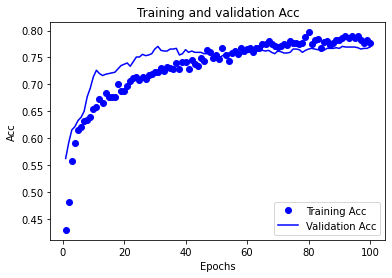

In [37]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [38]:
train_pred_nn = np.argmax(model.predict(train_set), axis=-1)
test_pred_nn = np.argmax(model.predict(test_set), axis=-1)

In [39]:
print_scores(train_label, train_pred_nn, test_label, test_pred_nn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7982975573649149
Accuracy test set:  0.8048359240069085

F1 score train set: 0.7967258995847363
F1 score test set:  0.8028508499340747
Train:
              precision    recall  f1-score   support

        High       0.73      0.67      0.70       638
      Medium       0.77      0.78      0.77      1189
         Low       0.88      0.92      0.90       875

    accuracy                           0.80      2702
   macro avg       0.79      0.79      0.79      2702
weighted avg       0.80      0.80      0.80      2702

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.73      0.68      0.70       274
      Medium       0.78      0.77      0.78       509
         Low       0.88      0.94      0.91       375

    accuracy                           0.80      1158
   macro avg       0.80      0.80      0.80      1158
weighted avg       0.80      0.80      0.80      1158



## Classification with Naive Bayes

In [40]:
gnb = GaussianNB().fit(train_set, train_label)

train_pred_gnb, test_pred_gnb = predict(gnb, train_set, test_set)

In [41]:
print_scores(train_label, train_pred_gnb, test_label, test_pred_gnb, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7538860103626943
Accuracy test set:  0.7633851468048359

F1 score train set: 0.7298401954589128
F1 score test set:  0.7401650753885773
Train:
              precision    recall  f1-score   support

        High       0.84      0.31      0.46       638
      Medium       0.67      0.86      0.76      1189
         Low       0.86      0.93      0.89       875

    accuracy                           0.75      2702
   macro avg       0.79      0.70      0.70      2702
weighted avg       0.77      0.75      0.73      2702

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.87      0.33      0.48       274
      Medium       0.68      0.87      0.76       509
         Low       0.86      0.94      0.90       375

    accuracy                           0.76      1158
   macro avg       0.81      0.71      0.71      1158
weighted avg       0.79      0.76      0.74      1158



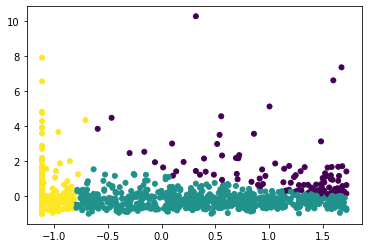

In [42]:

plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_gnb, s=25)
